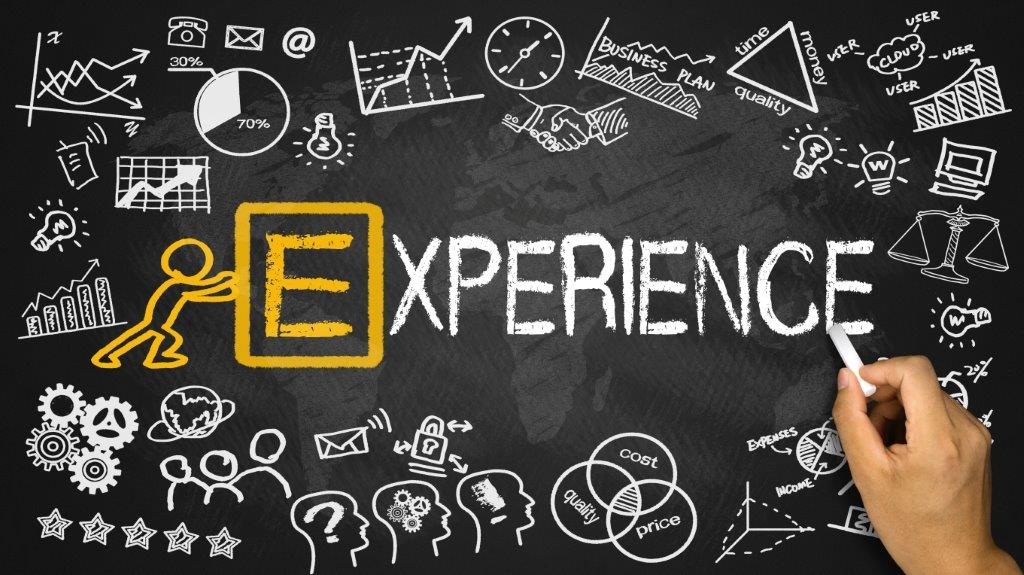
 </center>

# Giriş

<font color = 'green'>
İçerik: 
    
1. [Kütüphaneler ve veri yükleme](#1)
1. [Ön işleme](#2)
     * [Genel kontroller](#3)
     * [Gürültülü veri](#4)
     * [Karakter düzeltme işlemi](#5)
1. [Feature engineering](#6)
    * [Staj, Remote ve Sales Consultant değişkenleri](#7)
    * [City değişkeni](#8)
    * [Country değişkeni](#9)	
    * [Company - City incelemesi][#10)
    * [Company - Country incelemesi](#11)
    * [UserID - Staj incelemesi](#12)
    * [UserID - Remote incelemesi](#13)
    * [UserID - Sales Consultant incelemesi](#14)
    * [Veri setlerinin birleştirilmesi][#15)
    * [Eksik gözlemler](#16)
    * [Toplam çalışılan şirket](#17)
1. [Experiences veri seti oluşturma](#18)


<a id = "1"></a><br>
# 1. Kütüphaneler ve veri yükleme

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot
import matplotlib.pyplot as plt

%matplotlib inline
color = '#2ca25f'
cmap1 = 'Greens'
cmap2 =  'Set3'
palette1 = 'Greens'
palette2 = 'Set3'

root = '/kaggle/input/garanti-bbva-data-camp/'
target = 'moved_after_2019'
idx = 'user_id'

In [2]:
import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
df_exp   = pd.read_csv(os.path.join(root, 'work_experiences.csv'))
df_train = pd.read_csv(os.path.join(root, 'train_users.csv'))
df_test  = pd.read_csv(os.path.join(root, 'test_users.csv'))

df = pd.concat([df_train, df_test], axis=0)

<a id = "2"></a><br>
# 2. Ön işleme

<a id = "3"></a><br>
## 2.1 Genel kontroller

In [4]:
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187019 entries, 0 to 187018
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           187019 non-null  int64 
 1   company_id        187019 non-null  int64 
 2   location          125605 non-null  object
 3   start_year_month  187019 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 5.7+ MB


In [5]:
df_exp.head()

,user_id,company_id,location,start_year_month
0,53442,2651,"Istanbul, Turkey",201509
1,34558,815,"Istanbul, Turkey",201210
2,63761,26354,NaN,200010
3,10738,89,NaN,201610
4,8711,3113,"Istanbul, Turkey",201801


<a id = "4"></a><br>
## 2.2 Gürültülü veri

In [6]:
df_exp = df_exp[df_exp['start_year_month'] < 201901]
# https://www.kaggle.com/competitions/garanti-bbva-data-camp/discussion/383774

df_exp = df_exp.sort_values(by=['user_id', 'start_year_month']) 
# UserID ve StartYearMonth seviyesinde veri seti sıralandı.

df_exp.head()

,user_id,company_id,location,start_year_month
147720,0,0,Serbest Çalışmalar,200509
174454,0,0,Visual Studio Asp.Net Developer,200509
760,2,9,"Elazig, Turkey",201612
19762,2,7,"Elazig, Turkey",201706
180157,2,10,"Mersin, Turkey",201806


In [7]:
df_exp = df_exp.drop_duplicates(['user_id','company_id']) 
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136980 entries, 147720 to 108913
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           136980 non-null  int64 
 1   company_id        136980 non-null  int64 
 2   location          91746 non-null   object
 3   start_year_month  136980 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 5.2+ MB


* UserID ve CompanyID için 50.039 adet çoklanan değer veri setinden çıkarıldı.

<a id = "5"></a><br>
## 2.3 Karakter düzeltme işlemi

In [8]:
df_exp.location.value_counts().head(10)

Istanbul, Turkey     31374
İstanbul, Türkiye    10494
Ankara, Turkey        9991
Ankara, Türkiye       3560
Izmir, Turkey         3181
Kocaeli, Turkey       1777
İzmir, Türkiye        1351
İstanbul              1202
Turkey                1092
Ankara                 964
Name: location, dtype: int64

In [9]:
# sayıların ortadan kaldırılması;
df_exp['location'] = df_exp.location.str.replace('\d', '',regex = True)

# noktalama işaretlerinin ortadan kaldırılması;
df_exp['location'] = df_exp.location.str.replace('[^\w\s]', '',regex = True)

duzeltilecek_harfler = "çÇğĞıİöÖşŞüÜ"
duzeltilmis_harfler = "cCgGiIoOsSuU"
alfabe_duzeltme = str.maketrans(duzeltilecek_harfler, duzeltilmis_harfler)
df_exp['location'] = df_exp.location.str.translate(alfabe_duzeltme)
# Türkçe karakter düzeltme işlemi.

df_exp.location.value_counts().head(10)

Istanbul Turkey     31473
Istanbul Turkiye    10536
Ankara Turkey       10003
Ankara Turkiye       3568
Izmir Turkey         3342
Kocaeli Turkey       1777
Istanbul             1571
Izmir Turkiye        1353
Turkey               1092
Ankara                964
Name: location, dtype: int64

In [10]:
df_experiences = df_exp[df_exp['location'].notnull()]

* Boş değerler hariç tüm veri farklı bir dataframe'e alınıyor.

In [11]:
# Büyük harf dönüşümü.
df_experiences['location'] = df_experiences.location.apply(lambda x: " ".join(x.upper() for x in x.split()))

# boşluk silme;
df_experiences['location'] = df_experiences.location.str.strip()

df_experiences.head(10)

,user_id,company_id,location,start_year_month
147720,0,0,SERBEST CALISMALAR,200509
760,2,9,ELAZIG TURKEY,201612
19762,2,7,ELAZIG TURKEY,201706
180157,2,10,MERSIN TURKEY,201806
30839,5,15,ISTANBUL,201706
161935,7,21,ISTANBUL TURKEY,201607
17649,7,20,ELAZIG,201812
4573,10,27,ELAZIG TURKEY,201308
43293,10,26,ISTANBUL TURKEY,201805
142585,11,30,ISTANBUL TURKEY,201708


In [12]:
df_experiences.location.value_counts().head(20)

ISTANBUL TURKEY     31519
ISTANBUL TURKIYE    10557
ANKARA TURKEY       10020
ANKARA TURKIYE       3572
IZMIR TURKEY         3349
ISTANBUL             1842
KOCAELI TURKEY       1782
IZMIR TURKIYE        1355
TURKEY               1098
ANKARA               1010
KOCAELI TURKIYE       933
BURSA TURKEY          729
ESKISEHIR TURKEY      688
TURKIYE               685
SAKARYA TURKEY        594
ANTALYA TURKEY        474
MANISA TURKEY         434
ADANA TURKEY          382
IZMIR                 353
KAYSERI TURKEY        351
Name: location, dtype: int64

<a id = "6"></a><br>
# 3. Feature engineering


<a id = "7"></a><br>
## 3.1 Staj, Remote ve Sales Consultant değişkenleri

In [13]:
df_experiences.loc[df_experiences['location'].str.contains("STAJYER|INTERN"), 'STAJ'] = "STAJ"
df_experiences.loc[df_experiences['location'].str.contains("REMOTE"), 'REMOTE'] = "REMOTE"
df_experiences.loc[df_experiences['location'].str.contains("SALES CONSULTANT"), 'SALES_CONSULTANT'] = "SALES_CONSULTANT"

<a id = "8"></a><br>
## 3.2 City değişkeni

In [14]:
df_experiences.loc[df_experiences['location'].str.contains("ISTANBUL|MASLAK|BESIKTAS|UMRANIYE|ETILER|KOZYATAGI|YILDIZ TEKNIK|NISANTASI|BAGCILAR|KARTAL|YESILKOY|BAKIRKOY"), 'CITY'] = "ISTANBUL"
df_experiences.loc[df_experiences['location'].str.contains("ANKARA"), 'CITY'] = "ANKARA"
df_experiences.loc[df_experiences['location'].str.contains("IZMIR"), 'CITY'] = "IZMIR"
df_experiences.loc[df_experiences['location'].str.contains("KOCAELI|GEBZE"), 'CITY'] = "KOCAELI"
df_experiences.loc[df_experiences['location'].str.contains("BURSA"), 'CITY'] = "BURSA"
df_experiences.loc[df_experiences['location'].str.contains("ESKISEHIR"), 'CITY'] = "ESKISEHIR"
df_experiences.loc[df_experiences['location'].str.contains("SAKARYA"), 'CITY'] = "SAKARYA"
df_experiences.loc[df_experiences['location'].str.contains("MANISA"), 'CITY'] = "MANISA"
df_experiences.loc[df_experiences['location'].str.contains("ANTALYA"), 'CITY'] = "ANTALYA"
df_experiences.loc[df_experiences['location'].str.contains("ADANA"), 'CITY'] = "ADANA"
df_experiences.loc[df_experiences['location'].str.contains("KAYSERI"), 'CITY'] = "KAYSERI"
df_experiences.loc[df_experiences['location'].str.contains("KONYA"), 'CITY'] = "KONYA"
df_experiences.loc[df_experiences['location'].str.contains("TRABZON"), 'CITY'] = "TRABZON"
df_experiences.loc[df_experiences['location'].str.contains("TEKIRDAG"), 'CITY'] = "TEKIRDAG"
df_experiences.loc[df_experiences['location'].str.contains("MERSIN"), 'CITY'] = "MERSIN"
df_experiences.loc[df_experiences['location'].str.contains("MUGLA"), 'CITY'] = "MUGLA"
df_experiences.loc[df_experiences['location'].str.contains("ELAZIG"), 'CITY'] = "ELAZIG"
df_experiences.loc[df_experiences['location'].str.contains("ISPARTA"), 'CITY'] = "ISPARTA"
df_experiences.loc[df_experiences['location'].str.contains("DENIZLI"), 'CITY'] = "DENIZLI"
df_experiences.loc[df_experiences['location'].str.contains("ANTALYA"), 'CITY'] = "SAMSUN"
df_experiences.loc[df_experiences['location'].str.contains("GAZIANTEP"), 'CITY'] = "GAZIANTEP"
df_experiences.loc[df_experiences['location'].str.contains("EDIRNE"), 'CITY'] = "EDIRNE"
df_experiences.loc[df_experiences['location'].str.contains("BALIKESIR"), 'CITY'] = "BALIKESIR"
df_experiences.loc[df_experiences['location'].str.contains("KAHRAMANMARAS"), 'CITY'] = "KAHRAMANMARAS"
df_experiences.loc[df_experiences['location'].str.contains("SIVAS"), 'CITY'] = "SIVAS"
df_experiences.loc[df_experiences['location'].str.contains("YALOVA"), 'CITY'] = "YALOVA"

df_experiences.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91746 entries, 147720 to 91444
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           91746 non-null  int64 
 1   company_id        91746 non-null  int64 
 2   location          91746 non-null  object
 3   start_year_month  91746 non-null  int64 
 4   STAJ              309 non-null    object
 5   REMOTE            123 non-null    object
 6   SALES_CONSULTANT  90 non-null     object
 7   CITY              80195 non-null  object
dtypes: int64(3), object(5)
memory usage: 6.3+ MB


In [15]:
df_experiences.CITY.value_counts()

ISTANBUL         47384
ANKARA           15095
IZMIR             5360
KOCAELI           3767
ESKISEHIR         1129
BURSA             1124
SAKARYA            916
SAMSUN             775
MANISA             705
ADANA              581
KAYSERI            550
KONYA              535
TEKIRDAG           337
TRABZON            286
MERSIN             256
MUGLA              227
ELAZIG             186
GAZIANTEP          151
EDIRNE             147
BALIKESIR          146
DENIZLI            144
ISPARTA            142
KAHRAMANMARAS      112
YALOVA              91
SIVAS               49
Name: CITY, dtype: int64

<a id = "9"></a><br>
## 3.3 Country değişkeni

In [16]:
df_experiences.loc[df_experiences['CITY'].notnull(), 'COUNTRY'] = "TURKIYE"
df_experiences.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91746 entries, 147720 to 91444
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           91746 non-null  int64 
 1   company_id        91746 non-null  int64 
 2   location          91746 non-null  object
 3   start_year_month  91746 non-null  int64 
 4   STAJ              309 non-null    object
 5   REMOTE            123 non-null    object
 6   SALES_CONSULTANT  90 non-null     object
 7   CITY              80195 non-null  object
 8   COUNTRY           80195 non-null  object
dtypes: int64(3), object(6)
memory usage: 7.0+ MB


In [17]:
df_experiences.loc[~df_experiences['CITY'].isin(["ISTANBUL","ANKARA","IZMIR","KOCAELI","BURSA","ESKISEHIR","SAKARYA","MANISA","ANTALYA","ADANA","KAYSERI","KONYA","TRABZON","TEKIRDAG","MERSIN","MUGLA","ELAZIG","ISPARTA","DENIZLI","SAMSUN","GAZIANTEP","EDIRNE","BALIKESIR","KAHRAMANMARAS","SIVAS","YALOVA"]), 'CITY'] = "UNKNOWNCITY"

In [18]:
df_experiences.loc[df_experiences['location'].str.contains("TURKIYE|TURKEY"), 'COUNTRY'] = "TURKIYE"
df_experiences.loc[df_experiences['location'].str.contains("UNITED STATES|SAN FRANCISCO|LOS ANGELES|NEW YORK|NEW JERSEY|HOUSTON"), 'COUNTRY'] = "ABD"
df_experiences.loc[df_experiences['location'].str.contains("BARCELONA|SPAIN"), 'COUNTRY'] = "SPAIN"
df_experiences.loc[df_experiences['location'].str.contains("BERLIN|GERMAN"), 'COUNTRY'] = "GERMANY"
df_experiences.loc[df_experiences['location'].str.contains("LONDON|UNITED KINGDOM"), 'COUNTRY'] = "UK"
df_experiences.loc[df_experiences['location'].str.contains("ITALY"), 'COUNTRY'] = "ITALY"
df_experiences.loc[df_experiences['location'].str.contains("WUHAN|CHINA|CIN"), 'COUNTRY'] = "CHINA"
df_experiences.loc[df_experiences['location'].str.contains("YUNANISTAN|GREECE"), 'COUNTRY'] = "GREECE"
df_experiences.loc[df_experiences['location'].str.contains("STOCKHOLM|SWEDEN"), 'COUNTRY'] = "SWEDEN"

df_experiences.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91746 entries, 147720 to 91444
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           91746 non-null  int64 
 1   company_id        91746 non-null  int64 
 2   location          91746 non-null  object
 3   start_year_month  91746 non-null  int64 
 4   STAJ              309 non-null    object
 5   REMOTE            123 non-null    object
 6   SALES_CONSULTANT  90 non-null     object
 7   CITY              91746 non-null  object
 8   COUNTRY           84985 non-null  object
dtypes: int64(3), object(6)
memory usage: 7.0+ MB


In [19]:
df_experiences.loc[~df_experiences['COUNTRY'].isin(["TURKIYE","ABD","SPAIN","GERMANY","UK","ITALY","CHINA","GREECE","SWEDEN"]), 'COUNTRY'] = "UNKNOWNCOUNTRY"

In [20]:
df_experiences.COUNTRY.value_counts()

TURKIYE           83466
UNKNOWNCOUNTRY     6761
ABD                 564
GERMANY             428
UK                  182
SPAIN               155
ITALY                84
SWEDEN               52
CHINA                35
GREECE               19
Name: COUNTRY, dtype: int64

In [21]:
df_experiences.CITY.value_counts()

ISTANBUL         47384
ANKARA           15095
UNKNOWNCITY      11551
IZMIR             5360
KOCAELI           3767
ESKISEHIR         1129
BURSA             1124
SAKARYA            916
SAMSUN             775
MANISA             705
ADANA              581
KAYSERI            550
KONYA              535
TEKIRDAG           337
TRABZON            286
MERSIN             256
MUGLA              227
ELAZIG             186
GAZIANTEP          151
EDIRNE             147
BALIKESIR          146
DENIZLI            144
ISPARTA            142
KAHRAMANMARAS      112
YALOVA              91
SIVAS               49
Name: CITY, dtype: int64

<a id = "10"></a><br>
## 3.4 Company - City incelemesi

In [22]:
from scipy.stats import mode

In [23]:
df_companycity = df_experiences[df_experiences['CITY'].notnull()]
df_companycity  = df_companycity.pivot_table(index='company_id',values='CITY',aggfunc=lambda x: x.mode().iat[0])
df_companycity.columns = ['CITY']
df_companycity.head()

,CITY
company_id,
0,ISTANBUL
3,ISTANBUL
4,UNKNOWNCITY
5,ISTANBUL
6,MERSIN


<a id = "11"></a><br>
## 3.5 Company - Country incelemesi

In [24]:
df_companycountry = df_experiences[df_experiences['COUNTRY'].notnull()]
df_companycountry  = df_companycountry.pivot_table(index='company_id',values='COUNTRY',aggfunc=lambda x: x.mode().iat[0])
df_companycountry.columns = ['COUNTRY']
df_companycountry.head()

,COUNTRY
company_id,
0,TURKIYE
3,TURKIYE
4,TURKIYE
5,TURKIYE
6,TURKIYE


<a id = "12"></a><br>
## 3.6 UserID - Staj incelemesi

In [25]:
df_staj = df_experiences[df_experiences['STAJ'].notnull()]
df_staj  = df_staj.pivot_table(index='user_id',values='STAJ',aggfunc='nunique')
df_staj.columns = ['STAJ']
df_staj.head()

,STAJ
user_id,
237,1
384,1
624,1
679,1
702,1


<a id = "13"></a><br>
## 3.7 UserID - Remote incelemesi

In [26]:
df_remote = df_experiences[df_experiences['REMOTE'].notnull()]
df_remote  = df_remote.pivot_table(index='user_id',values='REMOTE',aggfunc='nunique')
df_remote.columns = ['REMOTE']
df_remote.head()

,REMOTE
user_id,
13,1
141,1
1505,1
1563,1
1614,1


<a id = "14"></a><br>
## 3.8 UserID - Sales Consultant incelemesi

In [27]:
df_sales_consultant = df_experiences[df_experiences['SALES_CONSULTANT'].notnull()]
df_sales_consultant = df_sales_consultant.pivot_table(index='user_id',values='SALES_CONSULTANT',aggfunc='nunique')
df_sales_consultant.columns = ['SALES_CONSULTANT']
df_sales_consultant.head()

,SALES_CONSULTANT
user_id,
37271,1
37602,1
37677,1
37697,1
37704,1


<a id = "15"></a><br>
## 3.9 Veri setlerinin birleştirilmesi

In [28]:
df_exp = df_exp.merge(df_staj , on="user_id", how="left") 
df_exp = df_exp.merge(df_sales_consultant, on="user_id", how="left") 
df_exp = df_exp.merge(df_remote, on="user_id", how="left") 

df_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136980 entries, 0 to 136979
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           136980 non-null  int64  
 1   company_id        136980 non-null  int64  
 2   location          91746 non-null   object 
 3   start_year_month  136980 non-null  int64  
 4   STAJ              968 non-null     float64
 5   SALES_CONSULTANT  210 non-null     float64
 6   REMOTE            501 non-null     float64
dtypes: float64(3), int64(3), object(1)
memory usage: 8.4+ MB


In [29]:
# df_companycountry
df_exp = df_exp.merge(df_companycountry , on="company_id", how="left") 

# df_companycity
df_exp = df_exp.merge(df_companycity , on="company_id", how="left") 

df_exp.head(10)

,user_id,company_id,location,start_year_month,STAJ,SALES_CONSULTANT,REMOTE,COUNTRY,CITY
0,0,0,Serbest Calismalar,200509,NaN,NaN,NaN,TURKIYE,ISTANBUL
1,2,9,Elazig Turkey,201612,NaN,NaN,NaN,TURKIYE,ELAZIG
2,2,7,Elazig Turkey,201706,NaN,NaN,NaN,TURKIYE,ELAZIG
3,2,10,Mersin Turkey,201806,NaN,NaN,NaN,TURKIYE,MERSIN
4,5,15,Istanbul,201706,NaN,NaN,NaN,TURKIYE,ISTANBUL
5,7,21,Istanbul Turkey,201607,NaN,NaN,NaN,TURKIYE,ISTANBUL
6,7,20,Elazig,201812,NaN,NaN,NaN,TURKIYE,ELAZIG
7,10,27,Elazig Turkey,201308,NaN,NaN,NaN,TURKIYE,ELAZIG
8,10,26,Istanbul Turkey,201805,NaN,NaN,NaN,TURKIYE,ISTANBUL
9,11,30,Istanbul Turkey,201708,NaN,NaN,NaN,TURKIYE,ISTANBUL


<a id = "16"></a><br>
## 3.10 Eksik gözlemler

In [30]:
df_exp["SALES_CONSULTANT"] = df_exp["SALES_CONSULTANT"].fillna(0).astype(int)
df_exp["REMOTE"] = df_exp["REMOTE"].fillna(0).astype(int)
df_exp["STAJ"] = df_exp["STAJ"].fillna(0).astype(int)

* Eksik gözlemler sıfır olarak dolduruldu.

In [31]:
df_exp['COUNTRY'] = df_exp['COUNTRY'].fillna(df_exp['COUNTRY'].mode()[0])
df_exp['CITY'] = df_exp['CITY'].fillna(df_exp['CITY'].mode()[0])

df_exp.head(10)

,user_id,company_id,location,start_year_month,STAJ,SALES_CONSULTANT,REMOTE,COUNTRY,CITY
0,0,0,Serbest Calismalar,200509,0,0,0,TURKIYE,ISTANBUL
1,2,9,Elazig Turkey,201612,0,0,0,TURKIYE,ELAZIG
2,2,7,Elazig Turkey,201706,0,0,0,TURKIYE,ELAZIG
3,2,10,Mersin Turkey,201806,0,0,0,TURKIYE,MERSIN
4,5,15,Istanbul,201706,0,0,0,TURKIYE,ISTANBUL
5,7,21,Istanbul Turkey,201607,0,0,0,TURKIYE,ISTANBUL
6,7,20,Elazig,201812,0,0,0,TURKIYE,ELAZIG
7,10,27,Elazig Turkey,201308,0,0,0,TURKIYE,ELAZIG
8,10,26,Istanbul Turkey,201805,0,0,0,TURKIYE,ISTANBUL
9,11,30,Istanbul Turkey,201708,0,0,0,TURKIYE,ISTANBUL


* City ve Country eksik gözlemleri Mod ile dolduruldu.

<a id = "17"></a><br>
## 3.11 Toplam çalışılan şirket

In [32]:
df_totalcompany = df_exp.pivot_table(index='user_id',values='company_id',aggfunc='nunique')
df_totalcompany.columns = ['TOTALCOMPANY']
df_totalcompany.head()

# df_totalcompany
df_exp = df_exp.merge(df_totalcompany , on="user_id", how="left") 

df_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136980 entries, 0 to 136979
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           136980 non-null  int64 
 1   company_id        136980 non-null  int64 
 2   location          91746 non-null   object
 3   start_year_month  136980 non-null  int64 
 4   STAJ              136980 non-null  int64 
 5   SALES_CONSULTANT  136980 non-null  int64 
 6   REMOTE            136980 non-null  int64 
 7   COUNTRY           136980 non-null  object
 8   CITY              136980 non-null  object
 9   TOTALCOMPANY      136980 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 11.5+ MB


In [33]:
df_exp.drop(columns=["location"], inplace = True)
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136980 entries, 0 to 136979
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           136980 non-null  int64 
 1   company_id        136980 non-null  int64 
 2   start_year_month  136980 non-null  int64 
 3   STAJ              136980 non-null  int64 
 4   SALES_CONSULTANT  136980 non-null  int64 
 5   REMOTE            136980 non-null  int64 
 6   COUNTRY           136980 non-null  object
 7   CITY              136980 non-null  object
 8   TOTALCOMPANY      136980 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 10.5+ MB


In [34]:
df_exp.head(10)

,user_id,company_id,start_year_month,STAJ,SALES_CONSULTANT,REMOTE,COUNTRY,CITY,TOTALCOMPANY
0,0,0,200509,0,0,0,TURKIYE,ISTANBUL,1
1,2,9,201612,0,0,0,TURKIYE,ELAZIG,3
2,2,7,201706,0,0,0,TURKIYE,ELAZIG,3
3,2,10,201806,0,0,0,TURKIYE,MERSIN,3
4,5,15,201706,0,0,0,TURKIYE,ISTANBUL,1
5,7,21,201607,0,0,0,TURKIYE,ISTANBUL,2
6,7,20,201812,0,0,0,TURKIYE,ELAZIG,2
7,10,27,201308,0,0,0,TURKIYE,ELAZIG,2
8,10,26,201805,0,0,0,TURKIYE,ISTANBUL,2
9,11,30,201708,0,0,0,TURKIYE,ISTANBUL,2


<a id = "18"></a><br>
# 4. Experiences veri seti oluşturma

In [35]:
df_exp = df_exp.sort_values(by=['user_id', 'start_year_month']) 

In [36]:
df_new = pd.DataFrame()

df_new['company(1th)'] = df_exp.groupby(idx)['company_id'].nth(-1).astype(str)
df_new['company(2th)'] = df_exp.groupby(idx)['company_id'].nth(-2).astype(str)
df_new['company(3th)'] = df_exp.groupby(idx)['company_id'].nth(-3).astype(str)

df_new['company_city(1th)'] = df_exp.groupby(idx)['CITY'].nth(-1).astype(str)
df_new['company_city(2th)'] = df_exp.groupby(idx)['CITY'].nth(-2).astype(str)
df_new['company_city(3th)'] = df_exp.groupby(idx)['CITY'].nth(-3).astype(str)

df_new['min_exp_time'] = df_exp.groupby(idx)['start_year_month'].min()
df_new['max_exp_time'] = df_exp.groupby(idx)['start_year_month'].max()

df_new['CITY'] = df_exp.groupby(idx)['CITY'].apply(lambda x: x.mode().iat[0])
df_new['COUNTRY'] = df_exp.groupby(idx)['COUNTRY'].apply(lambda x: x.mode().iat[0])

df_new['company_count_2018'] = df_exp[df_exp['start_year_month'].gt(201712)].groupby(idx).size()
df_new['company_count_2017'] = df_exp[df_exp['start_year_month'].gt(201612)].groupby(idx).size()
df_new['company_count_2016'] = df_exp[df_exp['start_year_month'].gt(201512)].groupby(idx).size()

df_exp = df_new
df_exp.head()

,company(1th),company(2th),company(3th),company_city(1th),company_city(2th),company_city(3th),min_exp_time,max_exp_time,CITY,COUNTRY,company_count_2018,company_count_2017,company_count_2016
user_id,,,,,,,,,,,,,
0,0,NaN,NaN,ISTANBUL,NaN,NaN,200509,200509,ISTANBUL,TURKIYE,NaN,NaN,NaN
2,10,7,9,MERSIN,ELAZIG,ELAZIG,201612,201806,ELAZIG,TURKIYE,1.000,2.000,3.000
5,15,NaN,NaN,ISTANBUL,NaN,NaN,201706,201706,ISTANBUL,TURKIYE,NaN,1.000,1.000
7,20,21,NaN,ELAZIG,ISTANBUL,NaN,201607,201812,ELAZIG,TURKIYE,1.000,1.000,2.000
10,26,27,NaN,ISTANBUL,ELAZIG,NaN,201308,201805,ELAZIG,TURKIYE,1.000,1.000,1.000


In [37]:
df_exp = df_exp.merge(df_totalcompany , on="user_id", how="left") 
df_exp = df_exp.merge(df_staj , on="user_id", how="left") 
df_exp = df_exp.merge(df_sales_consultant, on="user_id", how="left") 
df_exp = df_exp.merge(df_remote, on="user_id", how="left") 

df_exp.drop(columns=["min_exp_time","max_exp_time"], inplace = True)
df_exp.head(20)

,company(1th),company(2th),company(3th),company_city(1th),company_city(2th),company_city(3th),CITY,COUNTRY,company_count_2018,company_count_2017,company_count_2016,TOTALCOMPANY,STAJ,SALES_CONSULTANT,REMOTE
user_id,,,,,,,,,,,,,,,
0,0,NaN,NaN,ISTANBUL,NaN,NaN,ISTANBUL,TURKIYE,NaN,NaN,NaN,1,NaN,NaN,NaN
2,10,7,9,MERSIN,ELAZIG,ELAZIG,ELAZIG,TURKIYE,1.000,2.000,3.000,3,NaN,NaN,NaN
5,15,NaN,NaN,ISTANBUL,NaN,NaN,ISTANBUL,TURKIYE,NaN,1.000,1.000,1,NaN,NaN,NaN
7,20,21,NaN,ELAZIG,ISTANBUL,NaN,ELAZIG,TURKIYE,1.000,1.000,2.000,2,NaN,NaN,NaN
10,26,27,NaN,ISTANBUL,ELAZIG,NaN,ELAZIG,TURKIYE,1.000,1.000,1.000,2,NaN,NaN,NaN
11,29,30,NaN,ISTANBUL,ISTANBUL,NaN,ISTANBUL,TURKIYE,1.000,2.000,2.000,2,NaN,NaN,NaN
12,33,34,26,ISTANBUL,ANKARA,ISTANBUL,ISTANBUL,TURKIYE,1.000,1.000,1.000,4,NaN,NaN,NaN
13,36,37,NaN,UNKNOWNCITY,ISTANBUL,NaN,ISTANBUL,TURKIYE,1.000,1.000,1.000,2,NaN,NaN,1.000
14,41,NaN,NaN,ISTANBUL,NaN,NaN,ISTANBUL,TURKIYE,NaN,NaN,NaN,1,NaN,NaN,NaN


In [38]:
df_exp["SALES_CONSULTANT"] = df_exp["SALES_CONSULTANT"].fillna(0).astype(int)
df_exp["REMOTE"] = df_exp["REMOTE"].fillna(0).astype(int)
df_exp["STAJ"] = df_exp["STAJ"].fillna(0).astype(int)
df_exp["company_count_2018"] = df_exp["company_count_2018"].fillna(0).astype(int)
df_exp["company_count_2017"] = df_exp["company_count_2017"].fillna(0).astype(int)
df_exp["company_count_2016"] = df_exp["company_count_2016"].fillna(0).astype(int)

df_exp["company_city(2th)"] = df_exp["company_city(2th)"].fillna("None")
df_exp["company_city(3th)"] = df_exp["company_city(3th)"].fillna("None")

df_exp["company(2th)"] = df_exp["company(2th)"].fillna("None")
df_exp["company(3th)"] = df_exp["company(3th)"].fillna("None")

df_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53002 entries, 0 to 66273
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   company(1th)        53002 non-null  object
 1   company(2th)        53002 non-null  object
 2   company(3th)        53002 non-null  object
 3   company_city(1th)   53002 non-null  object
 4   company_city(2th)   53002 non-null  object
 5   company_city(3th)   53002 non-null  object
 6   CITY                53002 non-null  object
 7   COUNTRY             53002 non-null  object
 8   company_count_2018  53002 non-null  int64 
 9   company_count_2017  53002 non-null  int64 
 10  company_count_2016  53002 non-null  int64 
 11  TOTALCOMPANY        53002 non-null  int64 
 12  STAJ                53002 non-null  int64 
 13  SALES_CONSULTANT    53002 non-null  int64 
 14  REMOTE              53002 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 6.5+ MB


In [39]:
# from datetime import datetime
# import datetime as dt

# df_exp["min_exp_time"] = pd.to_datetime(df_exp["min_exp_time"], format='%Y%m').dt.to_period('m')
# df_exp["max_exp_time"] = pd.to_datetime(df_exp["max_exp_time"], format='%Y%m').dt.to_period('m')

# Modelde kullanılmadı.

* Yararlanılan kaynaklar;

            * https://www.kaggle.com/code/zeynepozisil/eda-for-garanti-bbva-data-camp
            * https://www.kaggle.com/code/greysky/randomforest-baseline
            
* Diğer veri seti incelemeleri için;
            
            * Education : https://www.kaggle.com/code/muratcakmak/preprocessing-eda-education
            * Skills : https://www.kaggle.com/code/muratcakmak/preprocessing-eda-skills
            * Language :  https://www.kaggle.com/code/muratcakmak/preprocessing-eda-language
           